In [1]:
from ipynb.fs.full._Functions import *

# Deutsch–Jozsa

The Deutsch-Jozsa algorithm was proposed by David Deutsch and Richard Jozsa (hence the name) in 1992; it marked a very important step for the field of quantum computing since it was the first example of how a quantum computer performs a task exponentially faster than any classical computer. More specifically, for an $n$-bit input, the classical algorithm has time complexity $\newcommand{\bigO}{\mathcal{O}}$$\bigO(2^n)$, while Deutsch-Jozsa algorithm has constant time complexity, i.e. $\bigO(1)$.

**The problem**

Given an unknown Boolean function $f$, which takes as input a string of 0's and 1's and returns either a 0 or 1. We know $f$ is either balanced (returns 0 for half the input and 1 for the other half) or constant (returns either 0 or 1 for all inputs) and our task is to determine which one it is. Mathematically written, our function is $f:\{0,1\}^n \rightarrow{} \{0,1\}$, meaning that it maps a $n$-bit string to 0 or 1.

**The oracle**

To implement $f$ in our quantum circuit, we are going to use an oracle. (An oracle is a "blackbox" that performs a certain operation without letting the rest of the circuit what's going on inside it.) Of course, we need to implement this oracle ourselves so we are going to know what is going inside it. 

**Note**: we will implement the Deutsch-Jozsa algorithm first with $n=1$ (called Deutsch's algorithm), go through it and at the end we will provide the generalization for any $n$.

To start, we are going to implement the oracle we need for this algorithm. We will make one function called `dj_oracle()` which takes two arguments:
- Oracle: 0 for a balanced oracle and 1 for a constant oracle (as defined above).
- Choice: for a balanced oracle, 0 will make the output the same as the input (i.e. $f(x)=x$) and 1 will make the output the opposite of the input (i.e. $f(x)=\lnot x$). For a constant oracle, 0 will make the output always 0 (i.e. $f(x)=0$) and the same for 1.

The code to make these oracles is the following:

In [16]:
def d_oracle(qc, oracle, choice):
    """
    Add oracle for Deutsch's algoritm, in the form of a gate, to quantum circuit.
    
    Parameters:
    -----------
    qc: QuantumCircuit
        Quantum circuit with 2 qubits.
    oracle: int
        Type of oracle. 0 for balanced and 1 for constant.
    choice: int
        Choice of oracle type. For a balanced oracle, 0 will make f(x)=x and 1 will make f(x)=¬x. 
        For a constant oracle, 0 will make f(x)=0 and 1 will make f(x)=1.
        
    Returns:
    --------
    qc: QuantumCircuit
        Quantum circuit with Deutsch's algorithm oracle added at the end.
    """
    qreg           = QuantumRegister(2, 'q')
    oracle_circuit = QuantumCircuit(qreg, name='$U_f$')
    
    # Balanced oracle
    if oracle == 0:
        if choice == 0:
            oracle_circuit.cx(0, 1)
        elif choice == 1:
            oracle_circuit.cx(0, 1)
            oracle_circuit.x(1)
            
    # Constant oracle
    elif oracle == 1:
        if choice == 0:
            pass # x is already initialized to 0
        elif choice == 1:
            oracle_circuit.x(1)
    
    # Turn oracle into single gate and append to qc
    oracle_gate = oracle_circuit.to_gate()
    qc.append(oracle_gate, [0, 1])
    
    return qc

Before going into each possible oracle, it is important to note that due to the requirement of quantum computation that all circuits are reversible, we cannot make our oracle lose any information of the inputs. Therefore, our oracle $U_f$ will take an input $\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$\ket{x}\ket{y}$ and map it to an output $\ket{x}\ket{y \oplus f(x)}$. In our implementation of the oracle, we will take $\ket{y}=\ket{0}$ to be the input, therefore we can simplify the action that $U_f$ takes to mapping $\ket{x}\ket{0}$ to $\ket{x}\ket{f(x)}$.

Now we can start going through our different oracles.
- Constant 0 oracle. As you can see in the function above, no gates are appended to the circuit. This is because $\ket{y}$ is already $\ket{0}$, therefore we don't need to apply any more gates.
- Constant 1 oracle. We just append an $\textbf{X}$ gate to $\ket{y}$. Since we know that $\textbf{X}: \ket{0} \rightarrow \ket{1}$, this gate is sufficient to make our oracle always output $\ket{1}$.
- Balanced 0 oracle. Remember that this will make $U_f: \ket{x}\ket{0} \rightarrow \ket{x}\ket{x}$. To make this oracle, we just apply a $\textbf{CX}$ gate with control qubit $\ket{x}$ and target qubit $\ket{y}$. Therefore, if $\ket{x}=\ket{0}$ no gate will be applied to $\ket{y}$ and it will stay in the $\ket{0}$ state. If $\ket{x}=\ket{1}$, an $\textbf{X}$ gate will be applied to $\ket{y}$ transforming it into state $\ket{1}$; these two cases satisfy the behavior we wanted.
- Balanced 1 oracle. Remember that this will make $U_f: \ket{x}\ket{0} \rightarrow \ket{x}\ket{\lnot x}$. Therefore, we can apply the gate from the previous oracle and then apply an $\textbf{X}$ gate to $\ket{y}$ to make it the opposite of $x$. 

With our oracle function, we can know build Deutsch's algorithm circuit that will make use of this oracle. The function used to build this circuit is the following:

In [17]:
def deutsch(oracle = None, choice = None):
    """
    Create quantum circuit implementing Deutsch's algorithm.
    
    Parameters:
    -----------
    oracle: int
        Type of oracle. 0 for balanced and 1 for constant.
    choice: int
        Choice of oracle type. For a balanced oracle, 0 will make f(x)=x and 1 will make f(x)=¬x. 
        For a constant oracle, 0 will make f(x)=0 and 1 will make f(x)=1.
        
    NOTE: if any parameter is set to none (default), the value will be randomized.    
    
    Returns:
    --------
    qc: QuantumCircuit
        Quantum circuit implementing Deutsch's algorithm.
    """
    # Randomize oracle and choice if not given
    if oracle == None:
        oracle = random.randint(0, 1)
    if choice == None:
        choice = random.randint(0, 1)
    
    
    qreg = QuantumRegister(2, 'q')
    creg = ClassicalRegister(1, 'c')
    qc   = QuantumCircuit(qreg, creg)
    
    # Prepare initial state
    qc.x(qreg[1])
    
    qc.barrier()
    
    # Put into superpusition
    qc.h(qreg)
    
    qc.barrier()
    
    # Add oracle
    d_oracle(qc, oracle, choice)
    
    qc.barrier()
    
    # Apply interference
    qc.h(qreg[0])
    
    qc.barrier()
    
    # Measure first qubit
    qc.measure(qreg[0], creg)
    
    # Return circuit
    return qc

The first thing our circuit does is apply an $\textbf{X}$ gate to our second qubit, which takes it to the $\ket{1}$ state (remember that all qubits at the beggining of a qiskit circuit are in state $\ket{0}$). This is going to be useful later on in the cirquit.

The next thing in our circuit is the one-qubit Quantum Fourier Transform (QFT); which is just a normal Hadamard gate. This will take the current state of our circtui, $\ket{0}\otimes\ket{1}$ to 
$$\frac{1}{2}\cdot\left(\ket{0}+\ket{1}\right)\otimes\left(\ket{0}-\ket{1}\right),$$
which will then go through the oracle we prepared previously.

Remember that our oracle $U_f$ will take a two qubit state $\ket{x}\ket{y}$ to $\ket{x}\ket{y \oplus f(x)}$. (While constructing the oracles we had in mind an output of the type $\ket{x}\ket{0}$, but this was just to facilitate the construction, the oracle works fine with other inputs.) Therefore, our oracle will turn the current state into 
$$ \frac{1}{2}\cdot\left(\ket{0}+\ket{1}\right)\otimes\left(\ket{0 \oplus f(x)}-\ket{1 \oplus f(x)}\right),$$
however, this doesn't helps us very much to solve our problem. Let's look at this state from another perspective.

Imagine that $f(x)=0$, this will make our state remain in the state it was before passing throught $U_f$. Now imagine that $f(x)=1$, this will make the second qubit change its signs and turn into $\ket{1}-\ket{0}$ (normalized). With this in mind, we can write the state above as
$$ \frac{1}{2}\cdot (-1)^{f(x)} \left(\ket{0}+\ket{1}\right)\otimes\left(\ket{0}-\ket{1}\right).$$
This is much more helpful to solve our problem. Remember that in this case $x$ is our first qubit, and therefore $\ket{0}+\ket{1}$ (normalized). This means that $f(x)$ in the equation above will be evaluated for both $f(0)$ and $f(1)$. Thus, we have the following cases:
- If $f(1)=f(0)$, which means that the oracle is constant, we will have either $(-1)(-1)$ or no $-1$ at all. Therefore, the state will not change.
- If $f(1)\not=f(0)$, which means that the oracle is balanced, we will have one $-1$. Therefore, the state will receive a relative phase of $-1$.

We will now focus only on the first qubit and the $H$ gate applied to it after the oracle.
- If the oracle is constant, the first qubit will be in state $\ket{0}+\ket{1}$ (normalized) and the Hadamard gate will take it to the $\ket{0}$ state. 
- If the oracle is balanced, the first qubit will be in state $\ket{0}-\ket{1}$ (normalized) and the Hadamard gate will take it to the $\ket{1}$ state. 

Then, we just measure our first qubit. Let's see how the whole circuit looks like.

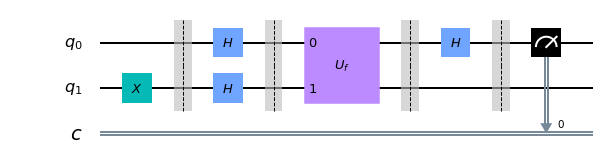

In [21]:
circ = deutsch()
draw(circ)

Based on the analysis above, if $\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$\ket{q_0}=0$, the oracle is constant, and if $\ket{q_0}=1$, the oracle is balanced. We can try this, we will make two circuits, one with a balanced oracle and one with a constant one and see what output we get.

In [32]:
circ_balanced = deutsch(0)
circ_constant = deutsch(1) # We will let the choice be random for both circuits

Results for balanced circuit:

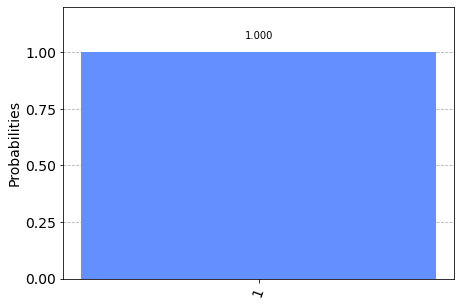

In [33]:
results, count_b = run(circ_balanced)
plot_histogram(count_b)

Results for constant circuit:

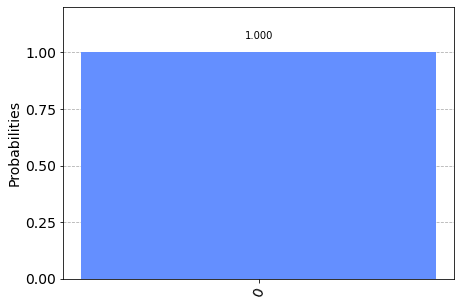

In [34]:
results, count_c = run(circ_constant)
plot_histogram(count_c)

As we can see, this results agree with what we expected.

**Generalizing**

With Deutsch's algorithm in place, we can generalize to the $n$ input Deutsch-Jozsa algorithm.